#Import Libs and Install Packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset # New ---> should be searched
from torch import autograd

import torchvision
from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image # New ---> Should be described

import matplotlib.pyplot as plt

# Configs

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 100

mnist_dim = 28*28

n_g = 256

z_dim = 100

lr = 0.0002

n_epochs = 200

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Data Preparation

In [12]:
transform = T.Compose([T.ToTensor(), ## 0-1
                       T.Normalize(0.5, 0.5)])

In [15]:
train_data = MNIST(root = './content/', download= True, train= True, transform = transform)
test_data = MNIST(root = './content/', download= True, train= False) # there is no need for test data for generation ---> or concat

In [16]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [17]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [18]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [19]:
train_data.data[5]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  13,  25, 100, 122,   7,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

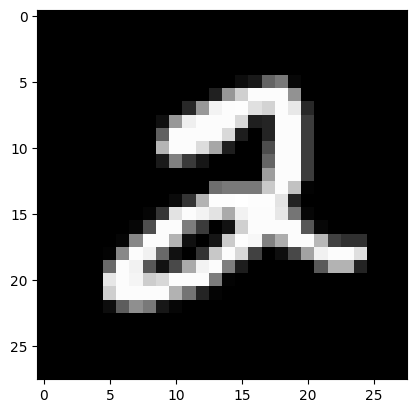

In [21]:
plt.imshow(train_data.data[5], cmap='gray')

In [24]:
dataloader = DataLoader(train_data, batch_size, True)

In [25]:
x, y = next(iter(dataloader))

In [26]:
x.shape, y

(torch.Size([100, 1, 28, 28]),
 tensor([4, 0, 7, 9, 5, 6, 1, 6, 4, 6, 1, 0, 9, 3, 2, 8, 9, 5, 1, 2, 1, 1, 2, 0,
         9, 3, 8, 1, 3, 8, 4, 4, 0, 9, 3, 6, 9, 4, 6, 9, 2, 6, 5, 7, 3, 4, 4, 9,
         5, 5, 0, 9, 4, 4, 3, 7, 0, 0, 2, 8, 4, 4, 6, 4, 1, 6, 7, 1, 5, 7, 5, 1,
         7, 8, 7, 1, 1, 5, 2, 5, 3, 7, 7, 9, 4, 7, 2, 7, 9, 6, 9, 2, 9, 4, 2, 6,
         7, 4, 5, 5]))

In [32]:
img_grid = make_grid(x, 10) # ncol --> Should be explained
img_grid.shape

torch.Size([3, 302, 302])

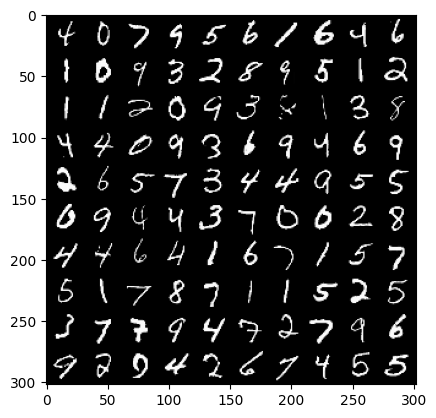

In [33]:
plt.imshow(img_grid.permute(1,2,0), cmap='gray') # channel conflict (PyTorch Vs Matplotlib, NumPy, CV2) --> Should be explained

# Simplified Traditional GAN

## Generator

In [34]:
class Generator(nn.Module):

  def __init__(self, neuron = 256):
    super(Generator, self).__init__()

    # self.layers = nn.ModuleList()
    # for l in range(nlayers): N = 3 , Neuron = 256
    #   self.layers.append(nn.LazyLinear(neuron*(l+1)))


    self.ln1 = nn.LazyLinear(neuron)  # in_features: Noise data; Noise data shape is cruicial here. Let us assume Z dim's is 100
    self.ln2 = nn.LazyLinear(neuron*2)
    self.ln3 = nn.LazyLinear(neuron*4)
    self.ln4 = nn.LazyLinear(out_features= mnist_dim) # flatten patches of MNIST data


  def forward(self, x):
    x = F.leaky_relu(self.ln1(x), 0.2)
    x = F.leaky_relu(self.ln2(x), 0.2)
    x = F.leaky_relu(self.ln3(x), 0.2)
    y = torch.tanh(self.ln4(x))
    return y

In [70]:
G = Generator(n_g)
G

Generator(
  (ln1): LazyLinear(in_features=0, out_features=256, bias=True)
  (ln2): LazyLinear(in_features=0, out_features=512, bias=True)
  (ln3): LazyLinear(in_features=0, out_features=1024, bias=True)
  (ln4): LazyLinear(in_features=0, out_features=784, bias=True)
)

In [41]:
G(torch.randn(100, z_dim)).shape #Should be explained

torch.Size([100, 784])

## Discriminator

In [37]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.ln1 = nn.LazyLinear(1024) # In_feat = 784 (Real and Fake)
    self.ln2 = nn.LazyLinear(512)
    self.ln3 = nn.LazyLinear(256)
    self.ln4 = nn.LazyLinear(1) # Binary CLF

  def forward(self, x):
    x = F.dropout(F.leaky_relu(self.ln1(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.ln2(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.ln3(x), 0.2), 0.3)
    y = torch.sigmoid(self.ln4(x))
    return y

In [38]:
D = Discriminator()
D

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Discriminator(
  (ln1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (ln2): LazyLinear(in_features=0, out_features=512, bias=True)
  (ln3): LazyLinear(in_features=0, out_features=256, bias=True)
  (ln4): LazyLinear(in_features=0, out_features=1, bias=True)
)

In [39]:
x.shape

torch.Size([100, 1, 28, 28])

In [40]:
x.flatten(1).shape

torch.Size([100, 784])

In [43]:
x_f = x.flatten(1)

D(x_f).shape

torch.Size([100, 1])

## Models

In [71]:
G = Generator().to(device)
G

Generator(
  (ln1): LazyLinear(in_features=0, out_features=256, bias=True)
  (ln2): LazyLinear(in_features=0, out_features=512, bias=True)
  (ln3): LazyLinear(in_features=0, out_features=1024, bias=True)
  (ln4): LazyLinear(in_features=0, out_features=784, bias=True)
)

In [72]:
D = Discriminator().to(device)
D

Discriminator(
  (ln1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (ln2): LazyLinear(in_features=0, out_features=512, bias=True)
  (ln3): LazyLinear(in_features=0, out_features=256, bias=True)
  (ln4): LazyLinear(in_features=0, out_features=1, bias=True)
)

## loss and opts

In [73]:
loss_fn = nn.BCELoss()

In [74]:
G_optimizer = optim.Adam(G.parameters(), lr)
D_optimizer = optim.Adam(D.parameters(), lr)

## Train Loop

In [75]:
loss_D_hist, loss_G_hist = [], []

In [76]:
for epoch in range(n_epochs):
  loss_D_avg, loss_G_avg = AverageMeter(), AverageMeter()
  for i , (x , _ ) in enumerate(dataloader): # What happend to y? explain... , X.shape ---> (100, 1, 28, 28) ---> (100,784)
    #==========================================#
                # Discriminator #
    #==========================================#
      D.zero_grad() # ----> ? Gradient acc VS D_optimizer.zero_grad()

    # Real data handling
      x_real = x.flatten(1).to(device)
      y_real = torch.ones(batch_size, 1).to(device) # one is artificial dim [100] ---> [100,1]

    # Further steps
    # real_data ----> D(real_data) ----> D_output ----> Loss_D(D_output, y_real)
      D_output = D(x_real)
      D_loss = loss_fn(D_output, y_real)

    # Noise and fake Data handling ----> fake_data = G(Z) ---> G_output = D(G(Z)) ---> Loss_G(G_output, y_fake) ----> Total D loss
      z = torch.randn(batch_size, z_dim).to(device) # dim ---> [100,100] ---> suitable for G net
      y_fake = torch.zeros(batch_size, 1).to(device) # torch zeros ---> Why? explain Dim... [100,1]

      x_fake = G(z)

      G_output = D(x_fake)
      G_loss = loss_fn(G_output, y_fake)

    # Total loss
      D_loss = G_loss + D_loss

    # Gradients and backprop

      D_loss.backward() # Important to be explained (D,G params)
      D_optimizer.step()
      #D_optimizer.zero_grad() Gradient acc

    #==========================================#
                  # Generator #
    #==========================================#
      G.zero_grad() # ----> ? Gradient acc VS G_optimizer.zero_grad()
    #Steps:
    # noise and fake data handling ----> out = D(G(z)) ----> loss_G(out, y_fake), where y_fake obtains 1 as label (G's Policy)


      z = torch.randn(batch_size, z_dim).to(device) # dim ---> [100,100] ---> suitable for G net
      y_real = torch.ones(batch_size, 1).to(device) # torch ones ---> Why? explain Dim...[100,1]

      output = D(G(z))

      G_loss = loss_fn(output, y_real)

      G_loss.backward()
      G_optimizer.step()
      #G_optimizer.zero_grad() Gradient acc

      loss_D_avg.update(D_loss.item())
      loss_G_avg.update(G_loss.item())

  loss_D_hist.append(loss_D_avg.avg)
  loss_G_hist.append(loss_G_avg.avg)

  with torch.no_grad():
    bs = 64
    z_test = torch.randn(bs, z_dim).to(device)
    outputs = G(z_test)
    save_image(outputs.view(bs, 1, 28, 28), f'./images/gan-{epoch:03d}.png')

  print(f'{epoch}/{n_epochs}: D Loss: {loss_D_avg.avg:.4f}, G Loss: {loss_G_avg.avg:.4f}')

0/200: D Loss: 1.0565, G Loss: 2.2094
1/200: D Loss: 0.9777, G Loss: 2.7451
2/200: D Loss: 1.1032, G Loss: 1.3846
3/200: D Loss: 0.7535, G Loss: 2.4197
4/200: D Loss: 0.5360, G Loss: 2.8960
5/200: D Loss: 0.5426, G Loss: 2.7187
6/200: D Loss: 0.5619, G Loss: 2.7152
7/200: D Loss: 0.6332, G Loss: 2.4092
8/200: D Loss: 0.6472, G Loss: 2.3761
9/200: D Loss: 0.6389, G Loss: 2.3500
10/200: D Loss: 0.6817, G Loss: 2.2443
11/200: D Loss: 0.7051, G Loss: 2.1507
12/200: D Loss: 0.7612, G Loss: 2.1020
13/200: D Loss: 0.7423, G Loss: 2.0787
14/200: D Loss: 0.7986, G Loss: 1.8732
15/200: D Loss: 0.8932, G Loss: 1.6733
16/200: D Loss: 0.8434, G Loss: 1.7960
17/200: D Loss: 0.8399, G Loss: 1.8131
18/200: D Loss: 0.8378, G Loss: 1.7983
19/200: D Loss: 0.8688, G Loss: 1.7181
20/200: D Loss: 0.8897, G Loss: 1.6559
21/200: D Loss: 0.8993, G Loss: 1.6296
22/200: D Loss: 0.9050, G Loss: 1.6368
23/200: D Loss: 0.9260, G Loss: 1.5951
24/200: D Loss: 0.9282, G Loss: 1.5892
25/200: D Loss: 0.9517, G Loss: 1.5

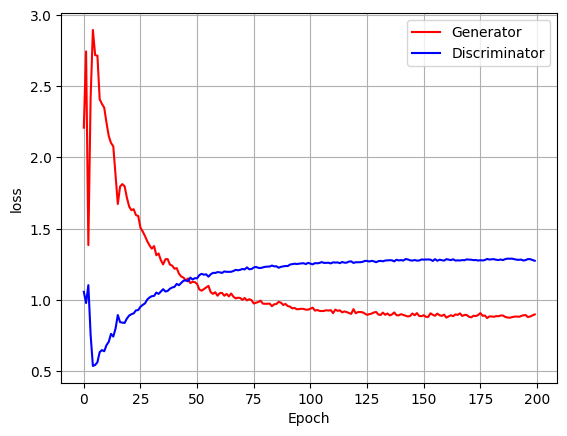

In [77]:
plt.plot(range(epoch+1), loss_G_hist, 'r-', label='Generator')
plt.plot(range(epoch+1), loss_D_hist, 'b-', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#DCGAN

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

paper:

# CGAN

https://github.com/qbxlvnf11/conditional-GAN

https://github.com/s-chh/Pytorch-cGAN-conditional-GAN/blob/main/cGAN.py#L67

https://medium.com/@simple.schwarz/how-to-build-a-cgan-for-generating-mnist-digits-in-pytorch-b74b59b77e7c

https://github.com/qbxlvnf11/conditional-GAN/blob/main/conditional-GAN-generating-fashion-mnist.ipynb ----> ipynb


paper:

In [79]:
i = torch.randn(10,100)
i_dim = 100
i.view(-1, i_dim).shape

torch.Size([10, 100])

#WGAN - GP

https://arxiv.org/abs/1701.07875 WGAN

https://arxiv.org/abs/1704.00028 WGAN-GP


https://github.com/EmilienDupont/wgan-gp/blob/master/training.py

## PyTorch Autograd Engine

In [3]:
x = torch.tensor([1., 3, 4], requires_grad= True)

y = x + x ** 3

autograd.grad(outputs = y , inputs = x, grad_outputs= torch.ones_like(y))

(tensor([ 4., 28., 49.]),)

In [87]:
x = torch.tensor([1., 2., -1], requires_grad= True)
w = torch.tensor(0.5, requires_grad= True)

y = w * x + x ** 3

autograd.grad(outputs = y , inputs = x, grad_outputs= torch.ones_like(y))

(tensor([ 3.5000, 12.5000,  3.5000]),)

In [88]:
x = torch.tensor([1., 2., -1], requires_grad= True)
w = torch.tensor(0.5, requires_grad= True)

y = w * x + x ** 3

autograd.grad(outputs = y , inputs = w, grad_outputs= torch.ones_like(y))

(tensor(2.),)

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), dtype=torch.float, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates).view(real_samples.size(0), -1)
    fake = torch.full((real_samples.shape[0], 1), 1.0, dtype=torch.float, device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates, # weights of D
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# If you want to dig in to the domain of GANs or other Generative Models

link: https://arxiv.org/abs/1801.04406#:~:text=Our%20analysis%20shows%20that%20GAN,converge%20to%20the%20equilibrium%20point.
